In [1]:
# Installing required library
!pip install kagglehub

In [2]:
# Link -> https://www.kaggle.com/datasets/sumedhkolupoti/brain-tumer-detection-dataset

In [4]:
# Downloading the dataset
import kagglehub
path = kagglehub.dataset_download('sumedhkolupoti/brain-tumer-detection-dataset')
print('Path to the dataset files :', path)

100%|██████████| 39.9M/39.9M [00:03<00:00, 13.6MB/s]

Extracting files...


Path to the dataset files : /root/.cache/kagglehub/datasets/sumedhkolupoti/brain-tumer-detection-dataset/versions/1


In [5]:
# Importing important libraries
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [10]:
# Dataset Paths
base_dir = "/root/.cache/kagglehub/datasets/sumedhkolupoti/brain-tumer-detection-dataset/versions/1/augmented data"

In [11]:
# Data Generators
train_datagen = ImageDataGenerator(rescale = 1./255, validation_split= 0.2)
train_gen = train_datagen.flow_from_directory(
    base_dir,
    target_size = (128, 128),
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'training',
    shuffle = True
)

val_gen = train_datagen.flow_from_directory(
    base_dir,
    target_size = (128, 128),
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'validation',
    shuffle = True
)

print("Classes :", list(train_gen.class_indices.keys()))

Found 1652 images belonging to 2 classes.
Found 413 images belonging to 2 classes.
Classes : ['no', 'yes']


In [12]:
# Sample Image Plot
def show_sample_images(generator):
  x, y = next(generator)
  plt.figure(figsize = (10, 3))
  for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(x[i])
    plt.title(list(train_gen.class_indices.keys())[np.argmax(y[i])])
    plt.axis('off')
  plt.suptitle('Sample Original Images')
  plt.show()

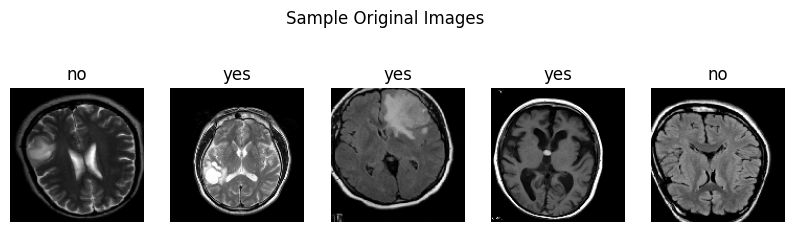

In [13]:
# Driver Code
show_sample_images(train_gen)

In [14]:
# Show Augmented Images
aug_datagen_display = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.3,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

In [15]:
# Function to get a random image path from a directory
def get_random_image_path(base_path):
  class_dirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
  random_class_dir = random.choice(class_dirs)
  random_class_path = os.path.join(base_path, random_class_dir)
  images = os.listdir(random_class_path)
  random_image_name = random.choice(images)
  return os.path.join(random_class_path, random_image_name)

In [16]:
# Dynamically get a sample image path
sample_image_path = get_random_image_path(base_dir)
print(f"Using sample image from  : {sample_image_path}")

Using sample image from  : /root/.cache/kagglehub/datasets/sumedhkolupoti/brain-tumer-detection-dataset/versions/1/augmented data/yes/aug_Y146_0_3091.jpg


In [17]:
# Getting the image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
img = load_img(sample_image_path, target_size = (128, 128))
x = img_to_array(img)
x = x.reshape((1, ) + x.shape) # Reshape to (1, 128, 128, 3)

In [18]:
# Writing a function for augmented image
def show_augmented_images_with_originals(img_array, datagen, num_images = 4):
  plt.figure(figsize = (15, 5))

  # Display Original Image
  plt.subplot(1, num_images + 1, 1)
  plt.imshow(img_array.reshape(128, 128, 3) / 255.0)
  plt.title('Original Image')
  plt.axis('off')

  # Display Augmented Images
  i = 2
  for batch in datagen.flow(img_array, batch_size = 1):
    plt.subplot(1, num_images + 1, i)
    plt.imshow(batch[0] / 255.0)
    plt.title(f"Augmented {i-1}")
    plt.axis('off')
    i += 1
    if i > num_images + 1:
      break

  plt.suptitle('Sample Images vs Augmented Images')
  plt.show()

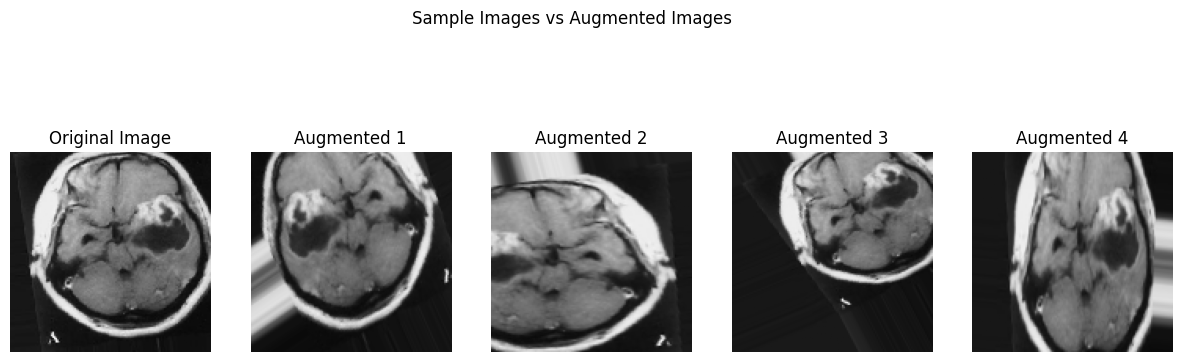

In [19]:
# Driver Code
show_augmented_images_with_originals(x, aug_datagen_display)

In [20]:
# Building the CNN Model
def build_cnn_model(num_filters = 32, num_hidden = 1, neurons = 64, dropout_rate = 0.3):
  model = Sequential()
  model.add(Conv2D(num_filters, (3, 3), activation = 'relu', input_shape = (128, 128, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(num_filters*2, (3, 3), activation = 'relu'))
  model.add(MaxPooling2D((2, 2)))

  model.add(Flatten())

  for _ in range(num_hidden):
    model.add(Dense(neurons, activation = 'relu'))
    model.add(Dropout(dropout_rate))

  model.add(Dense(len(train_gen.class_indices), activation = 'softmax'))
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model

In [21]:
# Training Multiple Models
configs = [
    {"num_filters": 32, "num_hidden": 1, "neurons": 64, "dropout_rate": 0.2},
    {"num_filters": 32, "num_hidden": 2, "neurons": 128, "dropout_rate": 0.3},
    {"num_filters": 64, "num_hidden": 3, "neurons": 256, "dropout_rate": 0.5}
]

# Early Stopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

In [22]:
# Loop
results = []
for cfg  in configs:
  print(f"\nTraining with config : {cfg}")
  model = build_cnn_model(**cfg)
  history = model.fit(
      train_gen,
      epochs = 10,
      validation_data = val_gen,
      callbacks = [early_stop],
      verbose = 1
  )
  val_acc = max(history.history['val_accuracy'])
  results.append((cfg, val_acc))


Training with config : {'num_filters': 32, 'num_hidden': 1, 'neurons': 64, 'dropout_rate': 0.2}
Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 0.6473 - loss: 0.6669 - val_accuracy: 0.7215 - val_loss: 0.5760
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.8122 - loss: 0.4435 - val_accuracy: 0.7215 - val_loss: 0.5805
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.8230 - loss: 0.4026 - val_accuracy: 0.7530 - val_loss: 0.6126
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.8828 - loss: 0.2671 - val_accuracy: 0.7869 - val_loss: 0.5792

Training with config : {'num_filters': 32, 'num_hidden': 2, 'neurons': 128, 'dropout_rate': 0.3}
Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 0.6086 - loss: 0.7996 - val_accuracy: 0.6877 - val_loss: 0.6129
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.7689 - loss: 0.5176 - val_accuracy: 0.7215 - val_loss: 0.5910
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 3

In [ ]:
'''
All the models are overfitted.
'''

In [23]:
# Getting the best model
print('\n Final Results :')
for cfg, acc in results:
  print(f"Config : {cfg} | Validation Accuracy : {acc}")


 Final Results :
Config : {'num_filters': 32, 'num_hidden': 1, 'neurons': 64, 'dropout_rate': 0.2} | Validation Accuracy : 0.7869249582290649
Config : {'num_filters': 32, 'num_hidden': 2, 'neurons': 128, 'dropout_rate': 0.3} | Validation Accuracy : 0.7845036387443542
Config : {'num_filters': 64, 'num_hidden': 3, 'neurons': 256, 'dropout_rate': 0.5} | Validation Accuracy : 0.7699757814407349
